## Scenario Descriptions

### CAGE Challenge 2

Your firm has been contracted by Florin to trial your new autonomous defence agents. Florin have given your agent authority to defend the computer network at one of their manufacturing plants. The network, shown in Figure 1, contains a user network for staff, an enterprise network, and an operational network which contains the key manufacturing and logistics servers. The defence agent receives an alert feed from Florin’s existing monitoring systems. It can run detailed analyses on hosts, then remove malicious software if found. If an attacker is too well established on a host to be removed, the host can be restored from a clean backup. Finally, the defence agent can deceive attackers by creating decoy services.

The network owner has undertaken an evaluation of the factory systems and contracted your firm to defend these systems according to the following criteria:

Maintain the critical operational server to ensure information about the new weapon system is not revealed to Guilder and the production and delivery of the new weapon system remains on schedule.
Where possible, maintain enterprise servers to ensure day-to-day operations of the manufacturing plant are not disrupted or revealed.”

Subnet 1 consists of user hosts that are not critical. \
Subnet 2 consists of enterprise servers designed to support the user activities on Subnet 1. \
Subnet 3 contains the critical operational server and three user hosts.

<img src="https://github.com/cage-challenge/cage-challenge-2/raw/main/images/figure1.png">

The effect of each action on the state of a targeted host is summarized with the diagram.

<img src="https://github.com/cage-challenge/cage-challenge-2/raw/main/images/figure2.png" caption="State Diagram">

### Appendix - Action Sets

Blue Action Sets
    
| Action     | Purpose                                                                                                                                                                                                                                                 | Parameters                                                                    | Output                                 |
|:-----------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:------------------------------------------------------------------------------|:---------------------------------------|
| Monitor | Collection of information about flagged malicious activity on the system\. Corresponds to action ID 1: Scan in the OpenC2 specification[^3]\.                                                                                                           | None *\(Note: This action occurs automatically if another action is chosen\)* | Network connections and associated processes that are identified as malicious\. |
| Analyse | Collection of further information on a specific host to enable blue to better identify if red is present on the system\. Corresponds to action ID 30: Investigate in the OpenC2 specification\.                                                         | Hostname                                                                      | Information on files associated with recent alerts including signature and entropy\.  |
| DecoyApache, DecoyFemitter, DecoyHarakaSMPT, DecoySmss, DecoySSHD, DecoySvchost, DecoyTomcat | Setup of a decoy service (as specified by the action name) on a specified host\. Green agents do not access these services, so any access is a clear example of red activity\.                                                                                                            | Hostname                                                                | An alert if the red agent accesses the new service\. |
| Remove | Attempting to remove red from a host by destroying malicious processes, files and services\. This action attempts to stop all processes identified as malicious by the monitor action\. Corresponds to action ID 10: Stop in the OpenC2 specification\. | Hostname                                                                      | Success/Failure |
| Restore | Restoring a system to a known good state\. This has significant consequences for system availability\. This action punishes Blue by \-1\. Corresponds to action ID 23: Restore in the OpenC2 specification\.                                            | Hostname                                                                      | Success/Failure  |


Red Action Sets
    
| Action     | Purpose                                                                                                                                                    | Parameters       | Output                                 |
|:-----------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------|:---------------------------------------|
| Discover Remote Systems | ATT&CK[^4] Technique T1018 Remote System Discovery\. Discovers new hosts/IP addresses in the network through active scanning using tools such as ping\.    | Subnet           | IP addresses in the chosen subnet from hosts that respond to ping |
| Discover Network Services | ATT&CK Technique T1046 Network Service Scanning. Discovers responsive services on a selected host by initiating a connection with that host\.              | Subnet           | Ports and service information |
| Exploit Network Services | ATT&CK Technique T1210 Exploitation of Remote Services\. This action attempts to exploit a specified service on a remote system\.                          | IP Address, Port | Success/Failure <br /> Initial recon of host if successful. |
| Escalate | ATT&CK Tactic TA0004 Privilege Escalation\. This action escalates the agent’s privilege on the host\.                                                      | Hostname         | Success/Failure <p> Internal information now available due to increased access to the host |
| Impact | ATT&CK Technique T1489 Service Stop\. This action disrupts the performance of the network and fulfils red’s objective of denying the operational service\. | Hostname         | Success/Failure  |

[^3]: Open Command and Control \(OpenC2\), [https://openc2\.org/](https://openc2\.org/)

[^4]: MITRE ATT&CK, [https://attack\.mitre\.org/](https://attack\.mitre\.org/)

### Agents

- Rules-based agents
- Deep Reinforcement Learning agents

### Rule-based agents

- Blue
    - RandomAgent: Takes a random action or a test action based on the epsilon value
    - BlueReactRemoveAgent: Adds suspicious hosts to the host list if the monitor finds something and then it will remove the program(session)
    - BlueReactRestoreAgent: Similar steps but restore the host from a cleaned backup.
- Red
    - RedMeanderAgent: Explores the network one subnet at a time, seeking to gain privileged access to all hosts in a subnet before moving on to the next one, eventually arriving at the Operational Server.
    - B_lineAgent: Attempts to move straight to the Operational Server using prior knowledge of the network layout.

In [10]:
# %pip list

In [1]:
import inspect
import time
import os
from statistics import mean, stdev
import random
import collections
from pprint import pprint

from CybORG import CybORG, CYBORG_VERSION

from CybORG.Agents import B_lineAgent, BlueReactRestoreAgent, BlueReactRemoveAgent, \
    RandomAgent, RedMeanderAgent, SleepAgent
from CybORG.Agents.MainAgent import MainAgent
from CybORG.Agents.MainAgent_cyborg_mm import MainAgent as MainAgent_cyborg_mm

from CybORG.Agents.Wrappers.ChallengeWrapper import ChallengeWrapper
from CybORG.Agents.Wrappers import EnumActionWrapper
from CybORG.Agents.Wrappers.FixedFlatWrapper import FixedFlatWrapper
from CybORG.Agents.Wrappers.IntListToAction import IntListToActionWrapper
from CybORG.Agents.Wrappers.OpenAIGymWrapper import OpenAIGymWrapper
from CybORG.Simulator.Scenarios.FileReaderScenarioGenerator import FileReaderScenarioGenerator

from CybORG.GameVisualizer.GameStateCollector import GameStateCollector
from CybORG.GameVisualizer.NetworkVisualizer import NetworkVisualizer

/home/ubuntu/justinyeh1995/CASTLEGym/castle.3.venv/lib/python3.10/site-packages/gym/wrappers/monitoring/video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn


path is: /home/ubuntu/justinyeh1995/CASTLEGym/CybORG/CybORG/env.py


In [2]:
# diagram.pyhps://diagrams.mingrammer.com/docs/getting-started/examples
# from diagrams import Diagram
# from diagrams.aws.compute import EC2
# from diagrams.aws.database import RDS
# from diagrams.aws.network import ELB

# with Diagram("Web Service", show=False):
#     ELB("lb") >> EC2("web") >> RDS("userdb")

## A Runner

In [3]:
# from CybORG.Tutorial.CybORG_As_A_Service import InteractiveCybORG

In [4]:
## Test InteractiveCybORG

## Visualization

- input 
    - Observation from Red and Blue
    - Action for Blue / Red?
    - link_diagram

Mouse over event oberservations 
Different Shape
Different State

In [5]:
MAX_EPS = 1
agent_name = 'Blue'
random.seed(0)
cyborg_version = CYBORG_VERSION
scenario = 'Scenario2'

def wrap(env):
    return ChallengeWrapper(env=env, agent_name='Blue')

def get_git_revision_hash() -> str:
    return subprocess.check_output(['git', 'rev-parse', 'HEAD']).decode('ascii').strip()


In [13]:
def main_cyborg_minus_minus():
    cyborg_version = CYBORG_VERSION
    scenario = 'Scenario2_cyborg--'
    # commit_hash = get_git_revision_hash()
    commit_hash = "Not using git"
    # ask for a name
    name = "CASTLEgym"
    # ask for a team
    team = "CardiffUni"
    # ask for a name for the agent
    name_of_agent = "PPO + Greedy decoys"

    lines = inspect.getsource(wrap)
    wrap_line = lines.split('\n')[1].split('return ')[1]

    # Change this line to load your agent
    agent = MainAgent_cyborg_mm()

    print(f'Using agent {agent.__class__.__name__}, if this is incorrect please update the code to load in your agent')

    file_name = str(inspect.getfile(CybORG))[:-10] + '/Evaluation/' + time.strftime("%Y%m%d_%H%M%S") + f'_{agent.__class__.__name__}.txt'

    path = str(inspect.getfile(CybORG))
    path = path[:-7] + f'/Simulator/Scenarios/scenario_files/Scenario2.yaml'
    sg = FileReaderScenarioGenerator(path)

    print(f'using CybORG v{cyborg_version}, {scenario}\n')
    
    # game manager initialization
    environment = 'sim'
    game_state_manager = GameStateCollector(environment=environment)
    
    for num_steps in [12]:
        for red_agent in [B_lineAgent]:
            red_agent = red_agent()
            cyborg = CybORG(sg, environment, agents={'Red': red_agent})
            wrapped_cyborg = wrap(cyborg)

            observation = wrapped_cyborg.reset()
            # observation = cyborg.reset().observation

            red_agent_name: str = red_agent.__class__.__name__
            blue_agent_name: str = agent.__class__.__name__
            
            # Set up game_state_manager
            game_state_manager.set_environment(cyborg=cyborg,
                                               red_agent_name=red_agent_name,
                                               blue_agent_name=blue_agent_name,
                                               num_steps=num_steps)
            game_state_manager.reset()

            action_space = wrapped_cyborg.get_action_space(agent_name)

            for i in range(MAX_EPS):
                r = []
                a = []
                
                # cyborg.env.env.tracker.render()
                for j in range(num_steps):
                    if environment == "sim":
                        action = agent.get_action(observation, action_space)
                        observation, rew, done, info = wrapped_cyborg.step(action)

                        actions = {"Red":str(cyborg.get_last_action('Red')), "Blue": str(cyborg.get_last_action('Blue'))}
                        observations = {"Red": cyborg.get_observation('Red'), "Blue": cyborg.get_observation('Blue')}
                        pprint(actions)
                        pprint(observations)

                    # Create state for this step
                    state_snapshot = game_state_manager.create_state_snapshot(actions, observations)
                    
                    game_state_manager.store_state(state_snapshot, i, j)
                    
                # game manager reset
                agent.end_episode()
                observation = wrapped_cyborg.reset()
                game_state_manager.reset()
                        
    return game_state_manager.get_game_state()

In [14]:
%%capture
test_cyborg_minus_minus = main_cyborg_minus_minus()

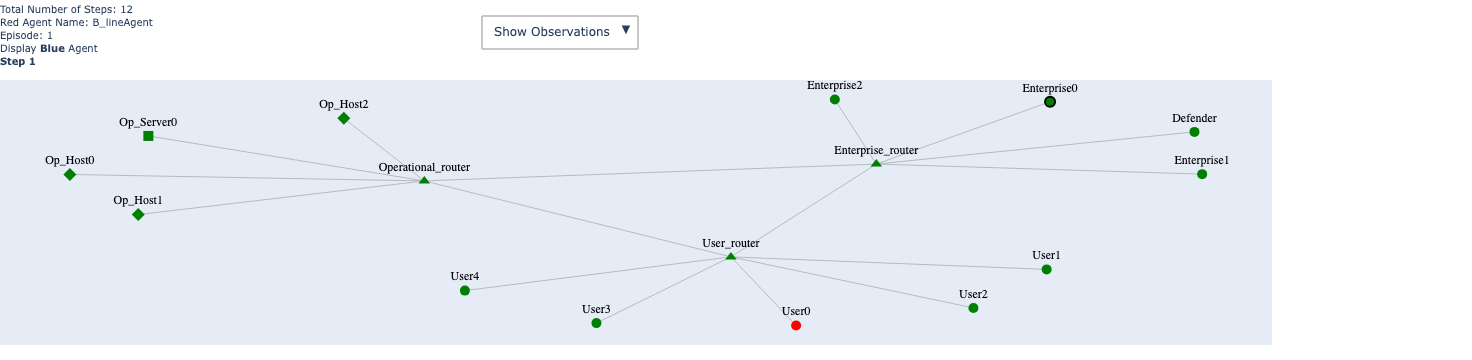

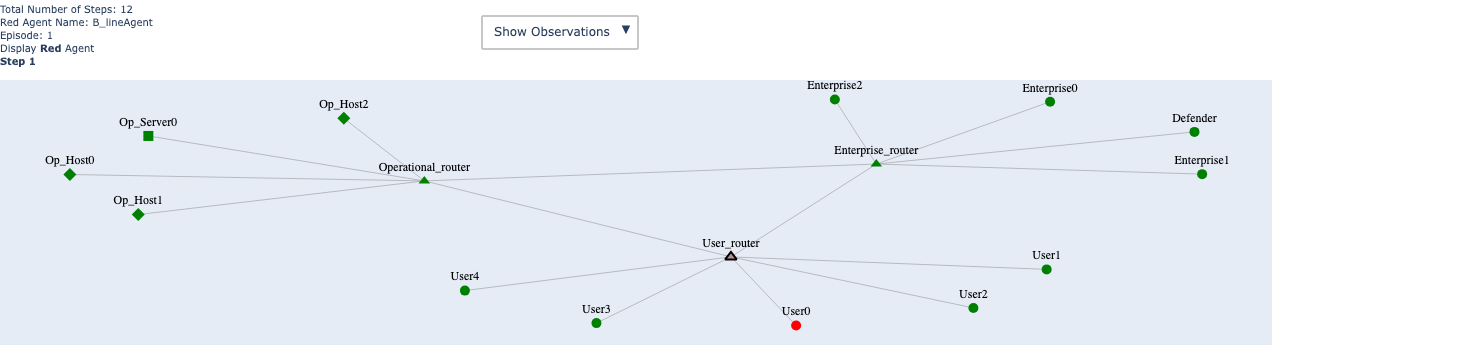

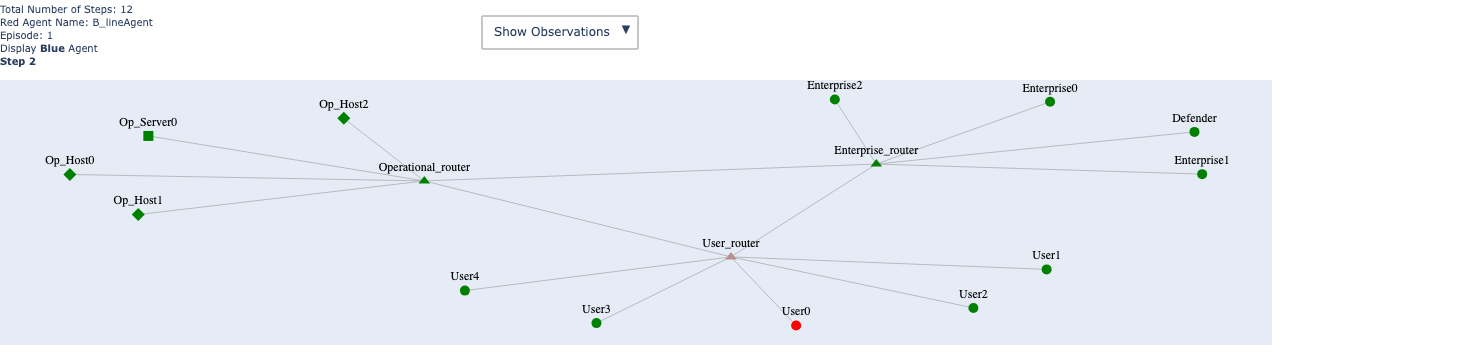

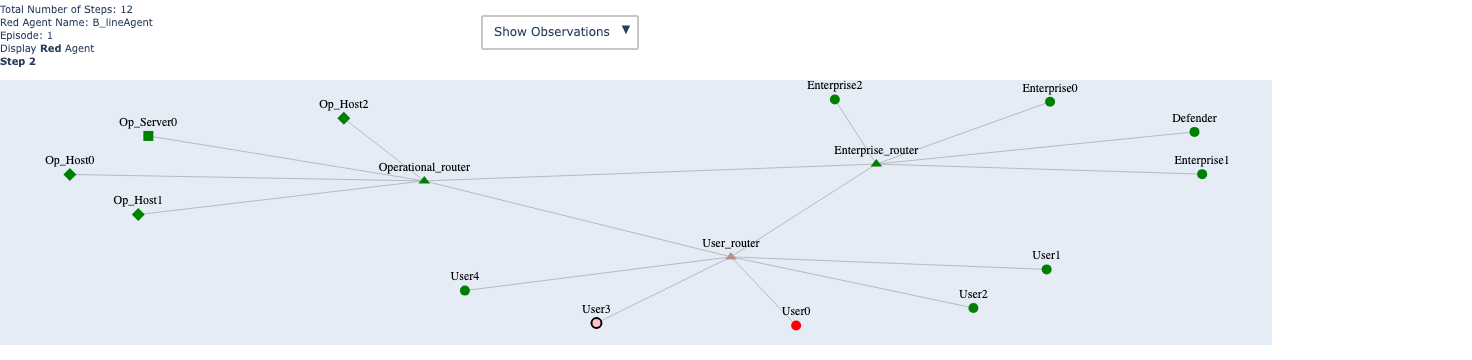

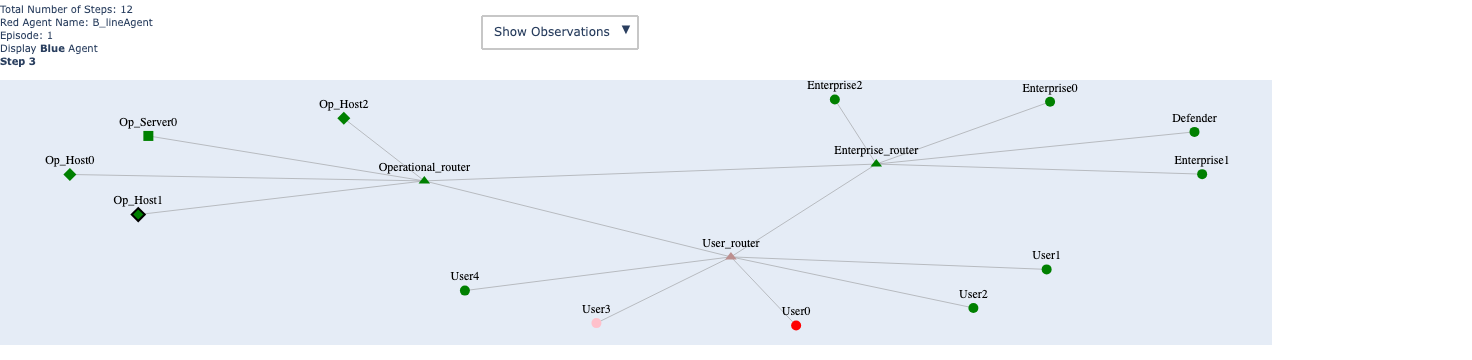

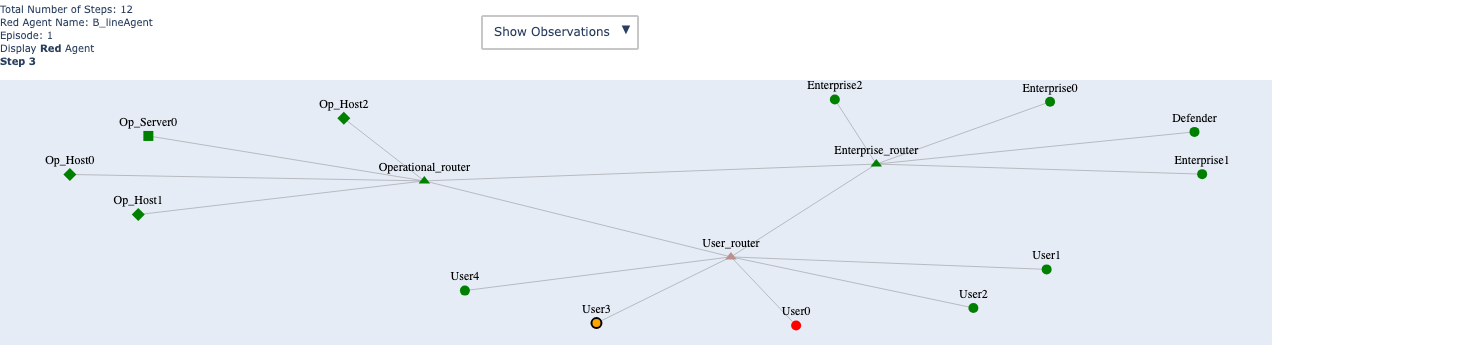

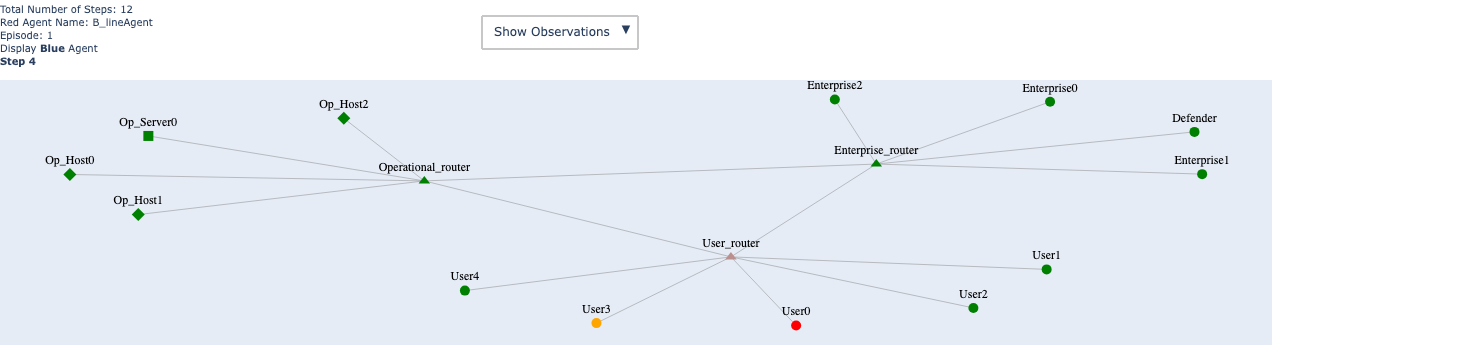

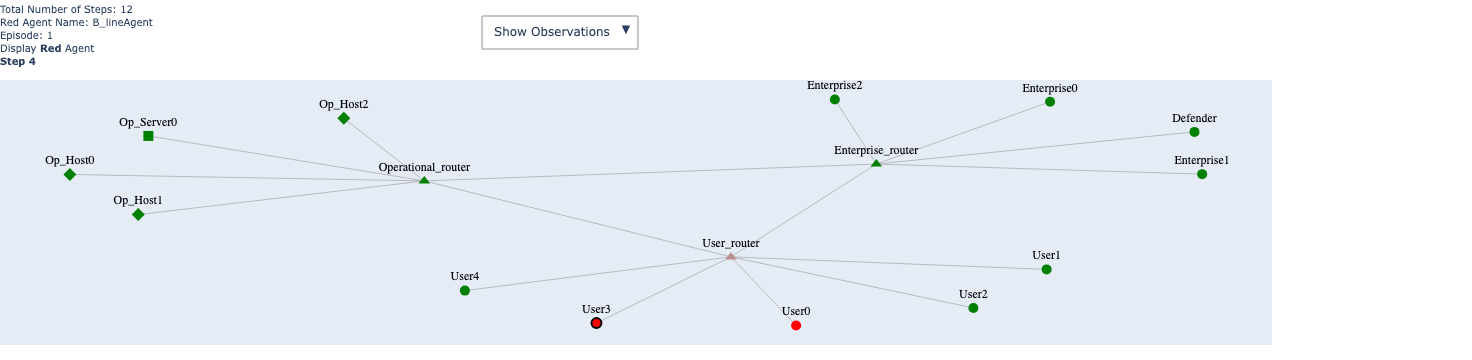

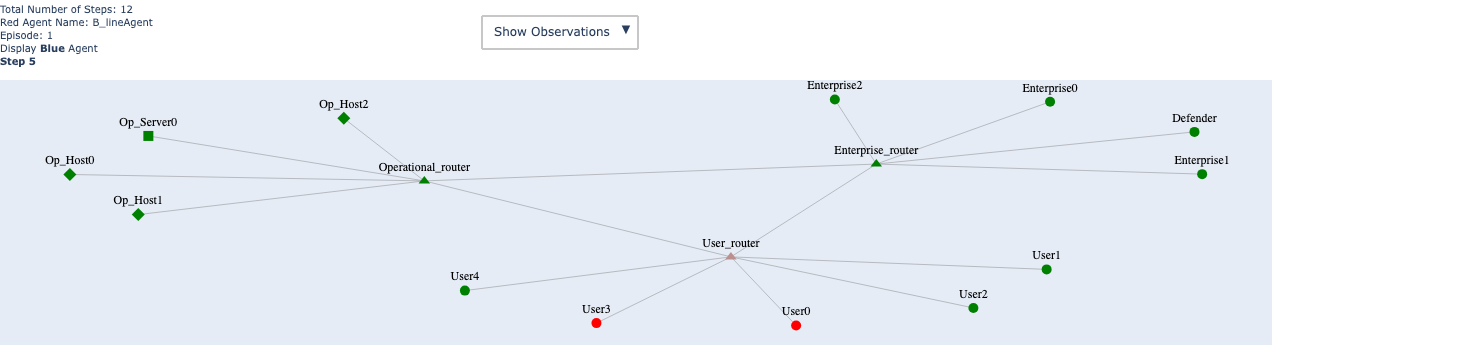

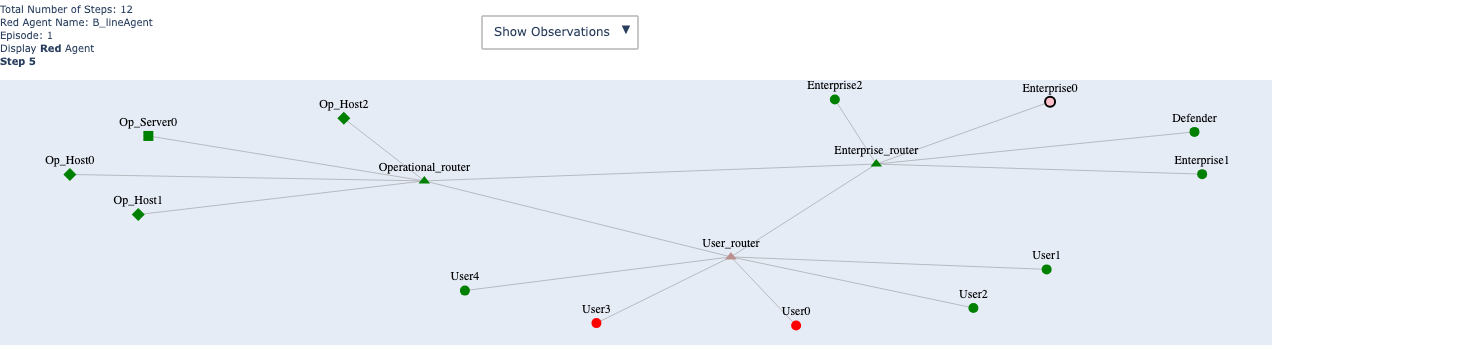

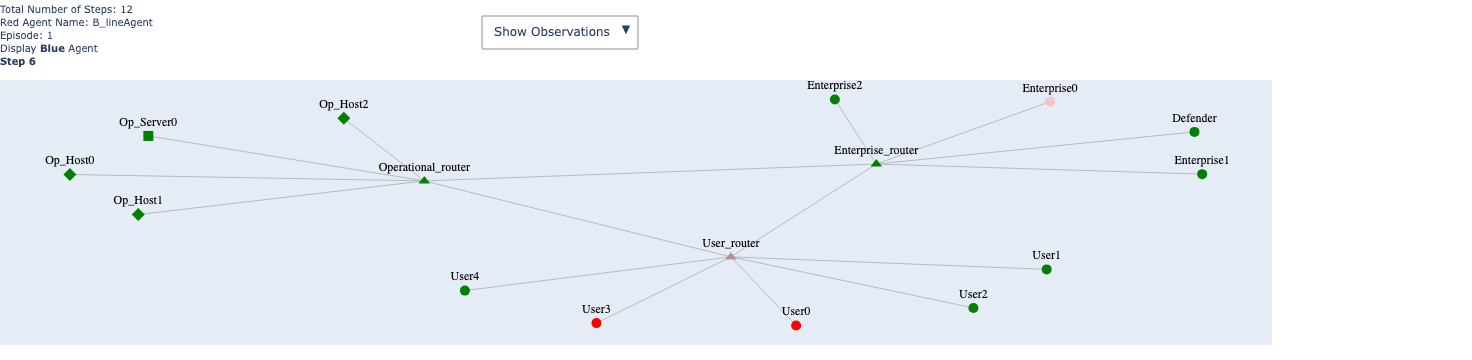

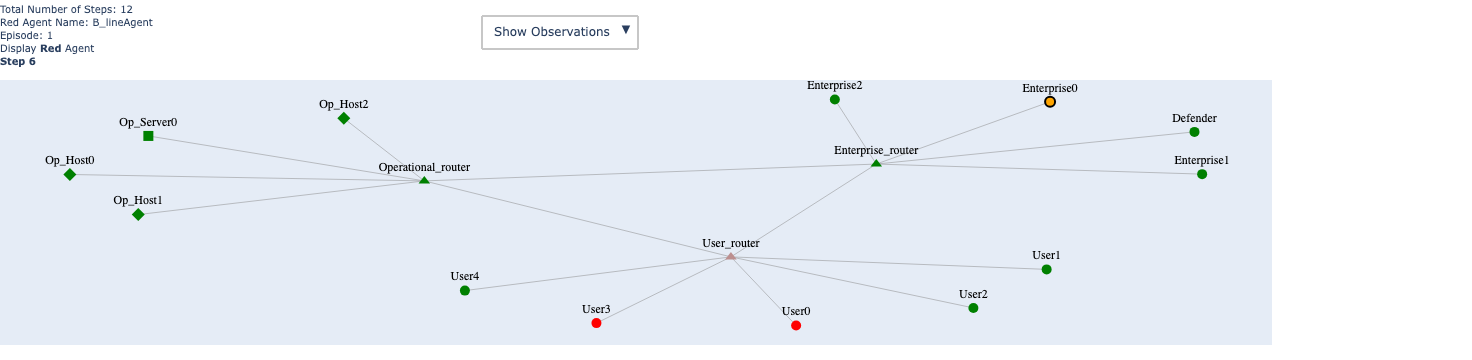

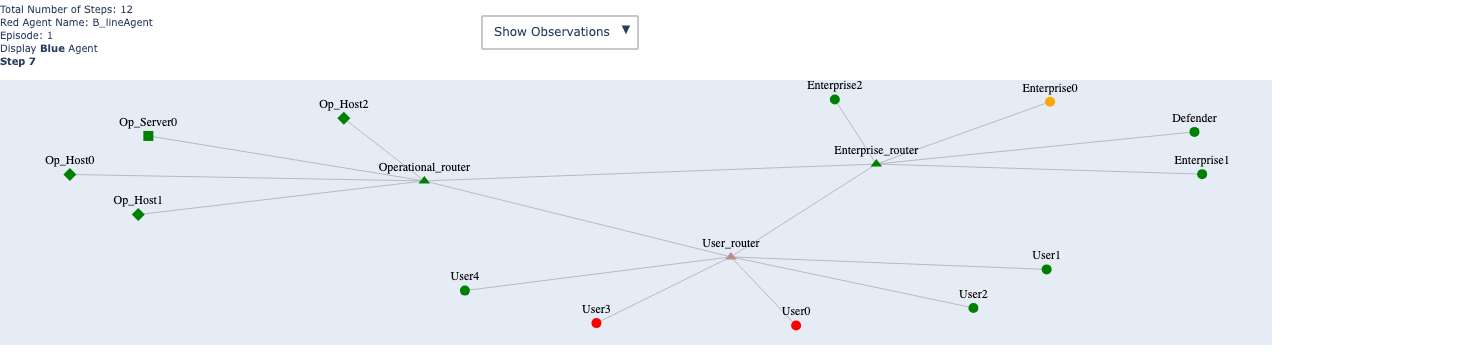

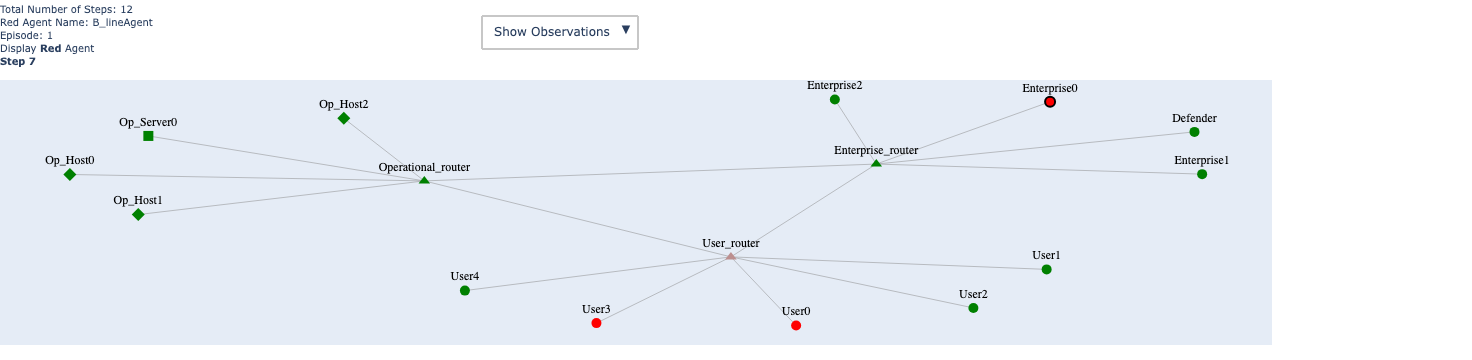

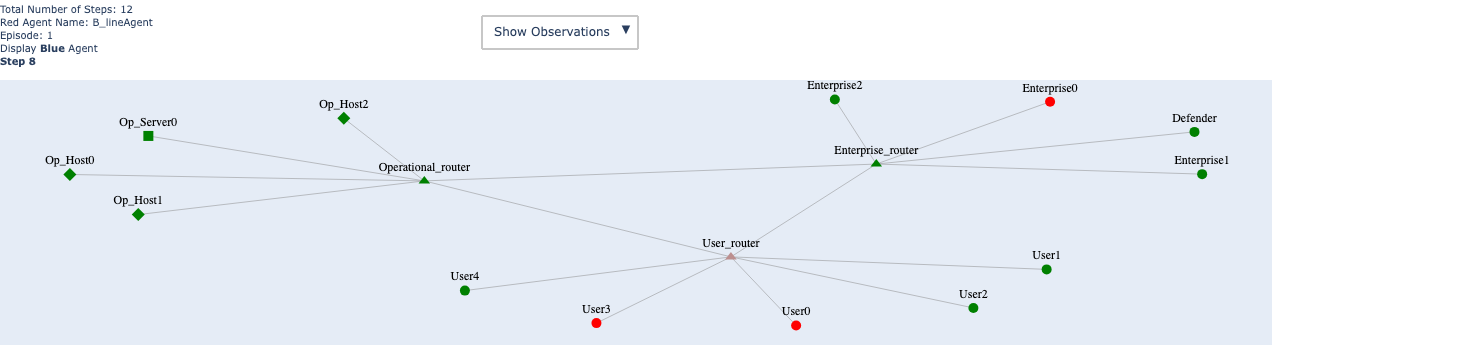

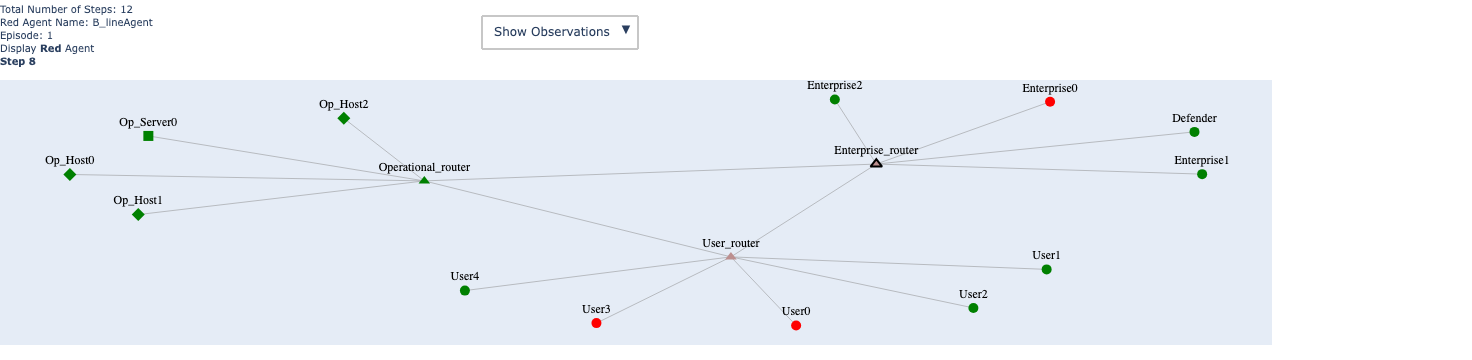

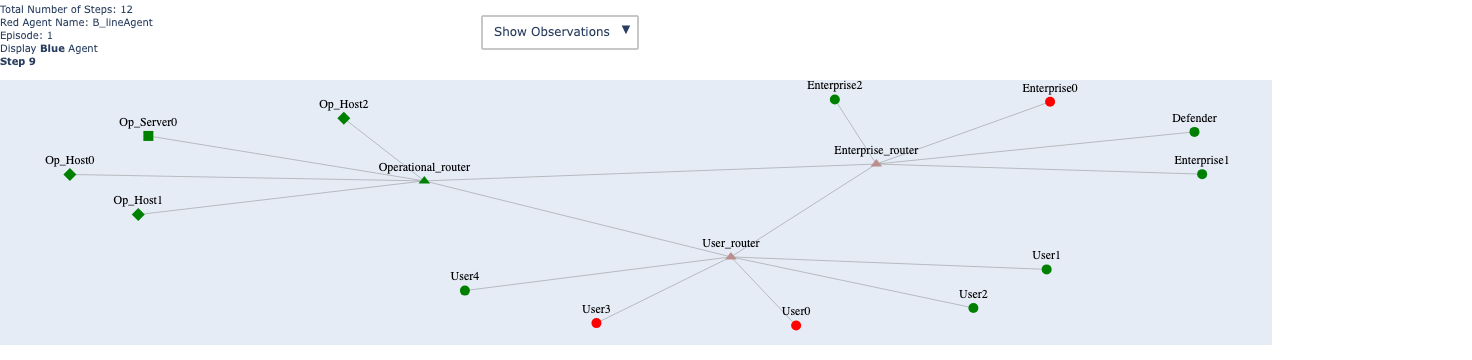

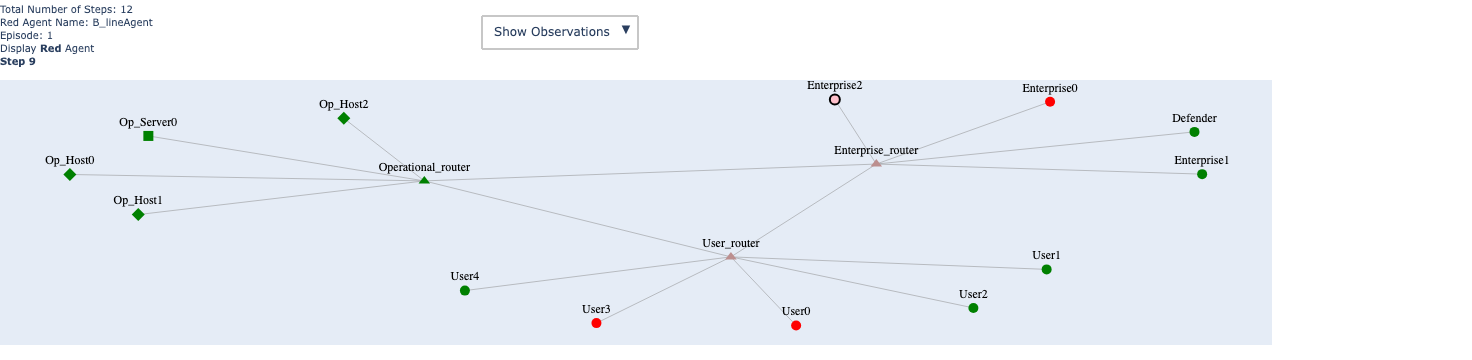

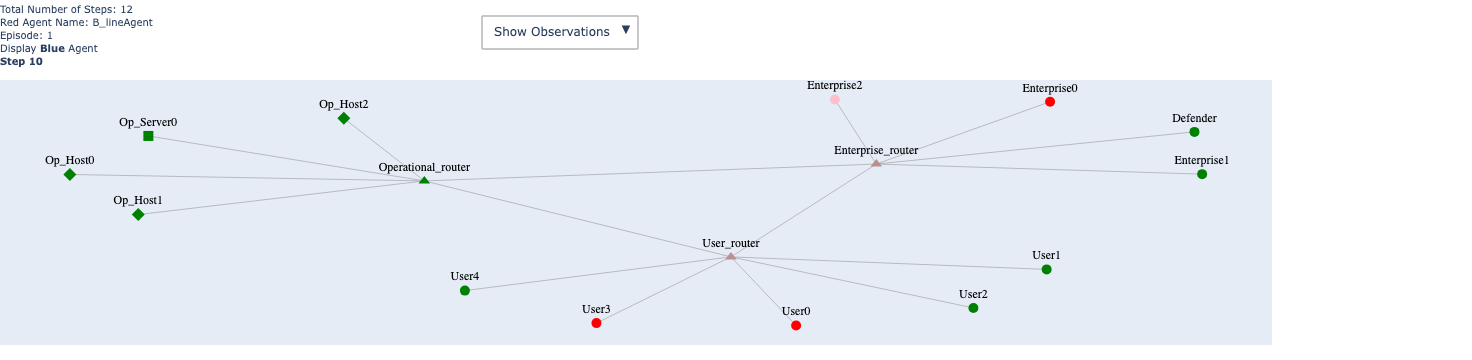

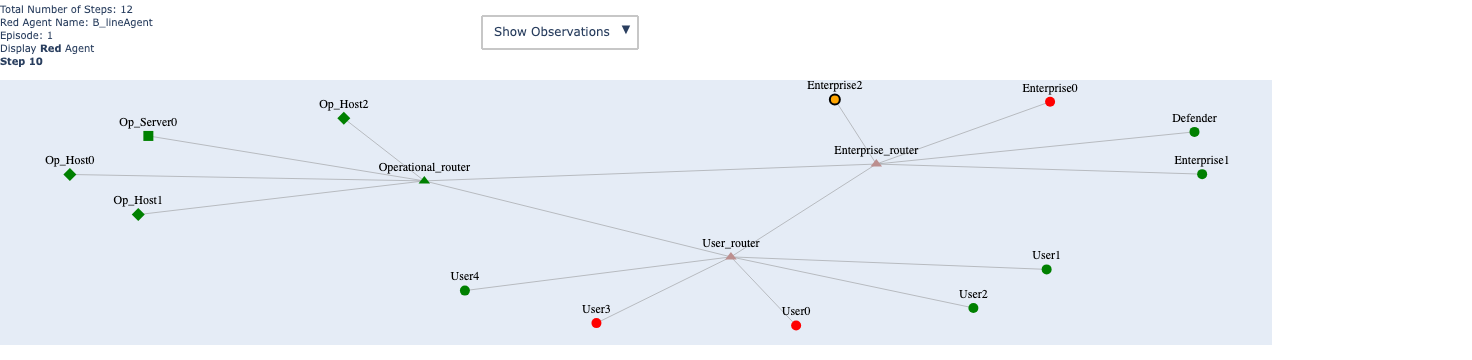

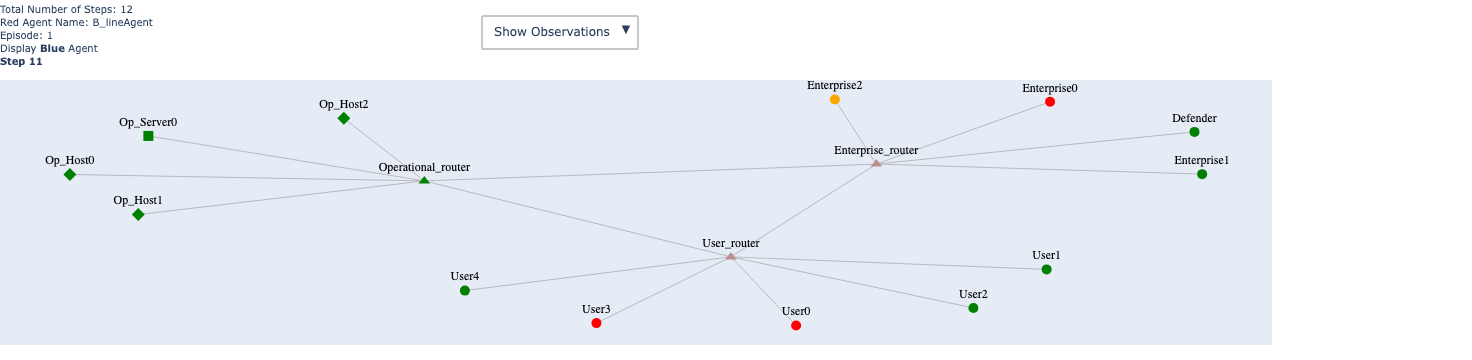

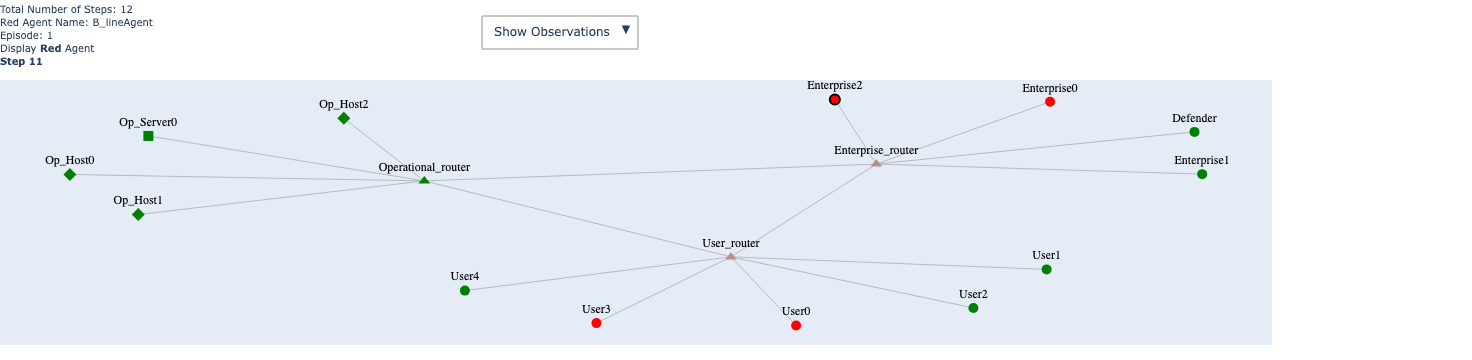

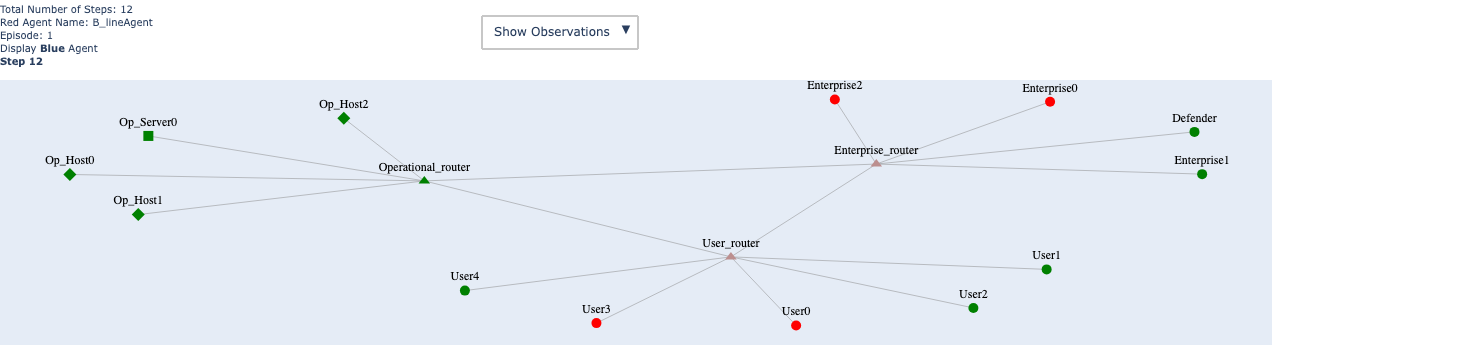

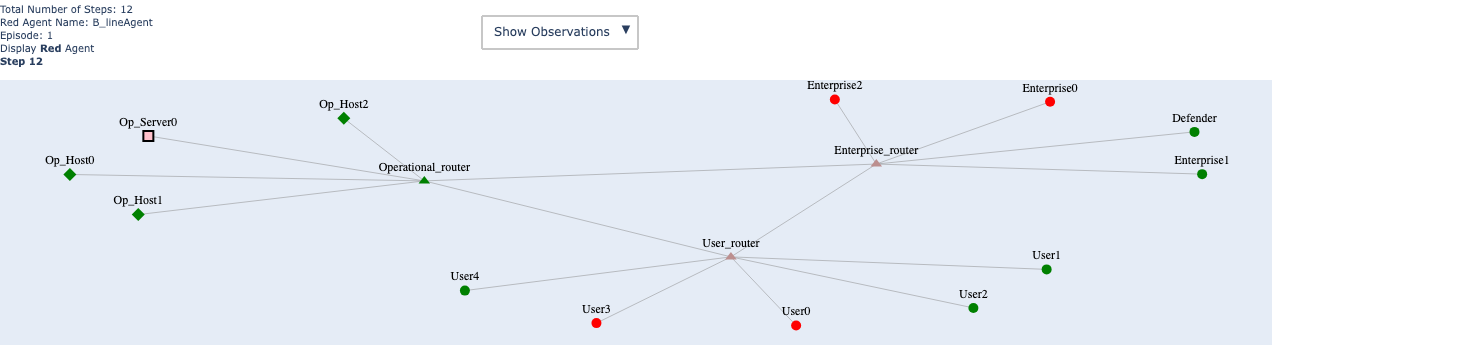

In [15]:
nv = NetworkVisualizer(test_cyborg_minus_minus)
nv.plot(save=False)

In [9]:
def main():
    cyborg_version = CYBORG_VERSION
    scenario = 'Scenario2'
    # commit_hash = get_git_revision_hash()
    commit_hash = "Not using git"
    # ask for a name
    name = "John Hannay"
    # ask for a team
    team = "CardiffUni"
    # ask for a name for the agent
    name_of_agent = "PPO + Greedy decoys"

    lines = inspect.getsource(wrap)
    wrap_line = lines.split('\n')[1].split('return ')[1]

    # Change this line to load your agent
    agent = MainAgent()
    
    print(f'Using agent {agent.__class__.__name__}, if this is incorrect please update the code to load in your agent')

    path = str(inspect.getfile(CybORG))
    path = path[:-7] + f'/Simulator/Scenarios/scenario_files/Scenario2.yaml'
    sg = FileReaderScenarioGenerator(path)

    print(f'using CybORG v{cyborg_version}, {scenario}\n')
    
    # game manager initialization
    game_state_manager = GameStateCollector()
    
    for num_steps in [3]:
        for red_agent in [B_lineAgent]:
            red_agent = red_agent()
            cyborg = CybORG(sg, 'sim', agents={'Red': red_agent})
            wrapped_cyborg = wrap(cyborg)

            observation = wrapped_cyborg.reset()
            # observation = cyborg.reset().observation

            # Rest set up game_state_manager
            game_state_manager.set_environment(cyborg=cyborg,
                                               red_agent=red_agent,
                                               blue_agent=agent,
                                               num_steps=num_steps)
            game_state_manager.reset()
            
            action_space = wrapped_cyborg.get_action_space(agent_name)
            # action_space = cyborg.get_action_space(agent_name)
            total_reward = []
            actions = []
            for i in range(MAX_EPS):
                r = []
                a = []
                
                # cyborg.env.env.tracker.render()
                for j in range(num_steps):
                    action = agent.get_action(observation, action_space)
                    observation, rew, done, info = wrapped_cyborg.step(action)
                    # result = cyborg.step(agent_name, action)
                    r.append(rew)
                    # r.append(result.reward)
                    a.append((str(cyborg.get_last_action('Blue')), str(cyborg.get_last_action('Red'))))
                    
                    # create state for this step
                    state_snapshot = game_state_manager.create_state_snapshot()
                    # game manager store state
                    game_state_manager.store_state(state_snapshot, i, j)
                    
                # game manager reset
                agent.end_episode()
                total_reward.append(sum(r))
                actions.append(a)
                # observation = cyborg.reset().observation
                observation = wrapped_cyborg.reset()
                game_state_manager.reset()

    return game_state_manager.get_game_state()

In [10]:
def main_simple_agent():
    cyborg_version = CYBORG_VERSION
    scenario = 'Scenario2'
    # commit_hash = get_git_revision_hash()
    commit_hash = "Not using git"
    # ask for a name
    name = "John Hannay"
    # ask for a team
    team = "CardiffUni"
    # ask for a name for the agent
    name_of_agent = "PPO + Greedy decoys"

    lines = inspect.getsource(wrap)
    wrap_line = lines.split('\n')[1].split('return ')[1]

    # Change this line to load your agent
    agent = BlueReactRemoveAgent()
    
    print(f'Using agent {agent.__class__.__name__}, if this is incorrect please update the code to load in your agent')

    path = str(inspect.getfile(CybORG))
    path = path[:-7] + f'/Tutorial/Scenario2_simple.yaml'

    sg = FileReaderScenarioGenerator(path)

    print(f'using CybORG v{cyborg_version}, {scenario}\n')
    
    # game manager initialization
    game_state_manager = GameStateCollector()
    
    for num_steps in [5]:
        for red_agent in [B_lineAgent]:
            red_agent = red_agent()
            cyborg = CybORG(sg, 'emu', agents={'Red': red_agent})

            observation = cyborg.reset()
            # print('observation is:',observation)
            
            # Rest set up game_state_manager
            game_state_manager.set_environment(cyborg=cyborg,
                                               red_agent=red_agent,
                                               blue_agent=agent,
                                               num_steps=num_steps)
            game_state_manager.reset()

            action_space = cyborg.get_action_space(agent_name)

            total_reward = []
            actions = []
            for i in range(MAX_EPS):
                r = []
                a = []
                
                # cyborg.env.env.tracker.render()
                for j in range(num_steps):
                    blue_action_space = cyborg.get_action_space('Blue')
                    blue_obs = cyborg.get_observation('Blue') # get the newest observation
                    blue_action = agent.get_action(blue_obs, blue_action_space)
                    # pprint(blue_action)
                        
                    result = cyborg.step('Blue', blue_action, skip_valid_action_check=False)
                    
                    # create state for this step
                    state_snapshot = game_state_manager.create_state_snapshot()

                    # game manager store state
                    game_state_manager.store_state(state_snapshot, i, j)

                # game manager reset
                agent.end_episode()
                total_reward.append(sum(r))
                actions.append(a)
                # observation = cyborg.reset().observation
                observation = cyborg.reset()
                # game state manager reset
                game_state_manager.reset()
                
    return game_state_manager.get_game_state()

In [13]:
# %%capture
# game_state_simple = main_simple_agent()


In [14]:
# game_state_simple

In [15]:
# nv = NetworkVisualizer(game_state_simple)
# nv.plot(save=False)

In [18]:
# %%capture
# game_state_pretained = main()

In [16]:
# nv = NetworkVisualizer(game_state_pretained)
# nv.plot(save=False)

In [17]:
# animation

# router blink
# surrond any change icon with dashlines(happnening this steps)

### Notes

1. Try scaling up the scenarios: 10,000 nodes

2. html panel / information panel / controller of the game which does animation (live/historical)


